In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from numba import jit
from scipy.optimize import fsolve

In [2]:

class Hydro:
    N = 10
    a = 0.0
    b = 1.0
    dx = 0.1
    t = 0.0
    cfl = 0.5
    
    gamma=1.4
    p_l=1.0
    rho_l=1.0
    v_l=1.0
    p_r=0.125
    rho_r=0.1
    v_r=0.0
    e_l=1.0
    e_r=1.0
    E_l=1.0
    E_r=1.0
    x = None
    U = None
    F = None
    ap=None
    am=None
    
    rho= None
    v=None
    p=None
    
    def __init__(self, N, a, b, t, cfl,p_l,p_r,rho_l,rho_r,v_l,v_r):
        if N%2!=0:
            N+=1
        mid=int(N/2)
        self.N = N
        self.a = a
        self.b = b
        self.t = t
        self.dx = (b-a) / float(N)
        self.p_l=float(p_l)
        self.p_r=float(p_r)
        self.rho_l=float(rho_l)
        self.rho_r=float(rho_r)
        self.v_l=float(v_l)
        self.v_r=float(v_r)
        self.U = np.empty([3,N]) #U-vector
        self.F = np.empty([3,N]) #F-vector
        
        self.x = a + self.dx*(np.arange(N)+0.5)
        self.cfl = float(cfl)
        self.e_l=self.p_l/(self.rho_l*(self.gamma-1.0))
        self.e_r=self.p_r/(self.rho_r*(self.gamma-1.0))
        self.E_l=self.rho_l*self.e_l+0.5*self.rho_l*(self.v_l**2)
        self.E_r=self.rho_r*self.e_r+0.5*self.rho_r*(self.v_r**2)
        
        self.U[0][:mid]=self.rho_l
        self.U[1][:mid]=self.rho_l*self.v_l
        self.U[2][:mid]=self.E_l
        self.U[0][mid:]=self.rho_r
        self.U[1][mid:]=self.rho_r*self.v_r
        self.U[2][mid:]=self.E_r
        self.F[0][:mid]=self.rho_l*self.v_l
        self.F[1][:mid]=self.rho_l*(self.v_l**2)+self.p_l
        self.F[2][:mid]=(self.E_l+self.p_l)*self.v_l
        self.F[0][mid:]=self.rho_r*self.v_r
        self.F[1][mid:]=self.rho_r*(self.v_r**2)+self.p_r
        self.F[2][mid:]=(self.E_r+self.p_r)*self.v_r
    
        
        
    
    def evolve(self, tfinal):
        
        while self.t < tfinal:
           
            #Calculate fluxes
            udot = self.Lu()
            
            dt = self.getDt()
            if self.t + dt > tfinal:
                dt = tfinal - self.t
                
            
            
            #update u
            self.U[:,1:-1] += dt*udot[:,1:-1]
            #Flux, boundaries ignored:
            #self.F[0][1:-1]=np.copy(self.U[1][1:-1])
            #self.F[1][1:-1]=np.copy(((self.U[1][1:-1]**2)/self.U[0][1:-1])\
                           # + (self.gamma-1.0)*(self.U[2][1:-1]-0.5*((self.U[1][1:-1]**2)/self.U[0][1:-1])))
            #self.F[2][1:-1]=np.copy((self.U[1][1:-1]/self.U[0][1:-1])*(self.U[2][1:-1]
                          #  +(self.gamma-1.0)*(self.U[2][1:-1]-0.5*((self.U[1][1:-1]**2)/self.U[0][1:-1]))))
                
            #Fluxes, not ignoring boundaries:
            self.F[0]=np.copy(self.U[1])
            self.F[1]=np.copy(((self.U[1]**2)/self.U[0])\
                            + (self.gamma-1.0)*(self.U[2]-0.5*((self.U[1]**2)/self.U[0])))
            self.F[2]=np.copy((self.U[1]/self.U[0])*(self.U[2]
                            +(self.gamma-1.0)*(self.U[2]-0.5*((self.U[1]**2)/self.U[0]))))
            self.t += dt
            
            #for animation:
        #line.set_data(self.x[1:-1] , self.U[0][1:-1])
        
        #return line,
        self.rho = self.U[0]
        self.v = self.U[1] / self.U[0]
        self.p = (self.gamma-1) * (self.U[2] - 0.5*self.U[1]*self.U[1]/self.U[0])
            
    def getDt(self):
        #rand=self.Lu()
        eigen=np.append(self.ap,self.am)
        thingy=np.fabs(eigen).max()
        if thingy==0:
            thingy=1
        return self.cfl * self.dx / thingy
    
    def Lu(self):
        
        ap = np.empty(self.N-1)
        am = np.empty(self.N-1)
            
        
        FL = self.F[:,:-1]
        FR = self.F[:,1:]
        UL = self.U[:,:-1]
        UR = self.U[:,1:]
        #UL=UL.astype('float')
        #UR=UR.astype('float')
        #FL=FL.astype('float')
        #FR=FR.astype('float')
        #csl=(self.gamma*(FL[1][:]-((UL[1][:]**2)/UL[0][:])))
        #csr=(self.gamma*(FR[1][:]-((UR[1][:]**2)/UR[0][:])))
        csl=self.gamma*(self.gamma-1.0)*(UL[2][:]-(0.5*UL[1][:]**2)/UL[0][:])
        csr=self.gamma*(self.gamma-1.0)*(UR[2][:]-(0.5*UR[1][:]**2)/UR[0][:])
        
       
        #for i in range(len(csl)):
         #   if csl[i]<=0:
                #print("ey!")
                
                
                
          #  if csr[i]<=0:
                #print("wey!")
                #lmr[i]=0
        
        lpl=(UL[1][:]/UL[0][:])+((csl/(UL[0][:])))**(1/2)
        lpr=(UR[1][:]/UR[0][:])+((csr/(UR[0][:])))**(1/2)
        lml=(UL[1][:]/UL[0][:])-((csl/(UL[0][:])))**(1/2)
        lmr=(UR[1][:]/UR[0][:])-((csr/(UR[0][:])))**(1/2)
        
            #if UL[0][i]==0:
             #   lpl[i]=0
              #  lml[i]=0
            #if UR[0][i]==0:
             #   lpr[i]=0
              #  lmr[i]=0
                
        
        for i in range(self.N-1):
            ap[i] = max(0, lpl[i], lpr[i])
            am[i] = max(0,-lml[i],-lmr[i])
        self.ap=ap
        self.am=am
        
        #apam=np.add(ap,am)
        FHLL = (ap*FL + am*FR - ap*am*(UR-UL)) / (ap+am)
        LU = np.empty([3,self.N])
        LU[:,1:-1] = -(FHLL[:,1:] - FHLL[:,:-1]) / self.dx
        
        return LU
    
    def plot(self, ax=None, filename=None):
        if ax is None:
            fig, ax = plt.subplots(3, sharex=True, figsize=(5,10))
        else:
            fig = ax.get_figure()
        
        ax[0].set_title("t = "+str(self.t), fontsize=24)
        ax[0].plot(self.x, self.rho, 'k-')
        ax[0].set_ylabel('rho', fontsize=16)
        ax[1].plot(self.x, self.v, 'k-')
        ax[1].set_ylabel('v', fontsize=16)
        ax[2].plot(self.x, self.p, 'k-')
        ax[2].set_ylabel('p', fontsize=16)
        ax[2].set_xlabel('x', fontsize=16)
        plt.tight_layout()
        #if ax is None:
        #    fig, ax = plt.subplots(1,3)
        #else:
        #    fig = ax.get_figure()
        #    
        #ax.plot(self.x[1:-1], self.U[0][1:-1], 'k-')
        #ax.set_xlabel(r'$X$')
        #ax.set_ylabel(r'$Density$')
        #ax.set_title("t = "+str(self.t))
        
        #if filename is not None:
         #   fig.savefig(filename)
            
        return ax

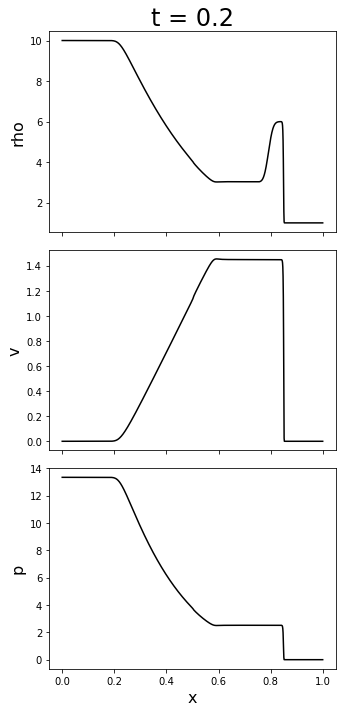

In [3]:
#(self, N, a, b, t, cfl,   p_l,p_r,  rho_l,rho_r,v_l,v_r)
test=Hydro(1000,0,1,0,0.5,13.33,1e-8,10.0,1.0,0.0,0.0)
#ax=test.densplot()
test.evolve(0.2)
#ay=test.plot()
test.plot()
plt.show()

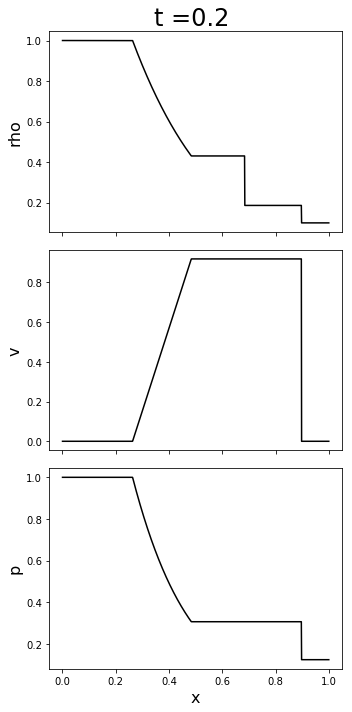

In [101]:
import math


def riemann(a, b, x0, N, T, rhoL, vL, PL, rhoR, vR, PR, gamma, 
                TOL=1.0e-14, MAX=100):
    # Returns the solution to the Riemann problem with left state (rhoL,vL,PL),
    # and right state (rhoR,vR,PR) after a time 'T' on a grid of N cells on
    # [a,b]. The initial discontinuity is placed at x0.
    #
    # Returns: X, rho, v, P

    AL = 2.0/((gamma+1.0)*rhoL)
    AR = 2.0/((gamma+1.0)*rhoR)
    BL = (gamma-1.0) / (gamma+1.0) * PL
    BR = (gamma-1.0) / (gamma+1.0) * PR
    csL = math.sqrt(gamma*PL/rhoL)
    csR = math.sqrt(gamma*PR/rhoR)

    p1 = 0.5*(PL + PR)
    p = p1
    i = 0
    dp = np.inf
    while abs(dp) > abs(p*TOL) and i < MAX:
        p = p1
        f1, df1 = riemann_f(p, rhoL, vL, PL, gamma, AL, BL, csL)
        f2, df2 = riemann_f(p, rhoR, vR, PR, gamma, AR, BR, csR)
        f = f1 + f2 + vR-vL
        df = df1 + df2

        dp = -f/df
        p1 = p + dp
        i += 1

    p = p1
    u = 0.5*(vL+vR) + 0.5*(riemann_f(p, rhoR, vR, PR, gamma, AR, BR, csR)[0]
                - riemann_f(p, rhoL, vL, PL, gamma, AL, BL, csL)[0])

    X = a + (b-a)/float(N) * (np.arange(N) + 0.5)
    xi = (X-x0)/float(T)

    rho = np.empty(X.shape)
    v = np.empty(X.shape)
    P = np.empty(X.shape)

    if p > PL:
        # Left Shock
        rhoLS = rhoL * (p/PL + (gamma-1.0)/(gamma+1.0)) / (
                (gamma-1.0)/(gamma+1.0) * p/PL + 1.0)
        SL = vL - csL*math.sqrt(((gamma+1) * p/PL + (gamma-1))/(2*gamma))

        iL = xi < SL
        iLS = (xi >= SL) * (xi < u)
        rho[iL] = rhoL
        v[iL] = vL
        P[iL] = PL
        rho[iLS] = rhoLS
        v[iLS] = u
        P[iLS] = p
    else:
        # Left Rarefaction
        rhoLS = rhoL * math.pow(p/PL, 1.0/gamma)
        csLS = csL * math.pow(p/PL, (gamma-1.0) / (2*gamma))
        SHL = vL - csL
        STL = u - csLS
        
        iL = xi < SHL
        ifan = (xi >= SHL) * (xi < STL)
        iLS = (xi >= STL)*(xi < u) 

        rho[iL] = rhoL
        v[iL] = vL
        P[iL] = PL
        rho[ifan] = rhoL * np.power(2.0/(gamma+1) + (gamma-1)/(gamma+1) 
                                    * (vL - xi[ifan]) / csL, 2.0/(gamma-1.0))
        v[ifan] = 2.0/(gamma+1) * (csL + 0.5*(gamma-1)*vL + xi[ifan])
        P[ifan] = PL * np.power(2.0/(gamma+1) + (gamma-1)/(gamma+1) 
                                * (vL - xi[ifan]) / csL, 2.0*gamma/(gamma-1.0))
        rho[iLS] = rhoLS
        v[iLS] = u
        P[iLS] = p

    if p > PR:
        # Right Shock
        rhoRS = rhoR * (p/PR + (gamma-1.0)/(gamma+1.0)) / (
                (gamma-1.0)/(gamma+1.0) * p/PR + 1.0)
        SR = vR + csR*math.sqrt(((gamma+1) * p/PR + (gamma-1))/(2*gamma))

        iR = xi >= SR
        iRS = (xi < SR) * (xi >= u)
        rho[iR] = rhoR
        v[iR] = vR
        P[iR] = PR
        rho[iRS] = rhoRS
        v[iRS] = u
        P[iRS] = p
    else:
        # Right Rarefaction
        rhoRS = rhoR * math.pow(p/PR, 1.0/gamma)
        csRS = csR * math.pow(p/PR, (gamma-1.0) / (2*gamma))
        SHR = vR + csR
        STR = u + csRS
        
        iR = xi >= SHR
        ifan = (xi < SHR) * (xi >= STR)
        iRS = (xi < STR)*(x >= u) 

        rho[iR] = rhoR
        v[iR] = vR
        P[iR] = PR
        rho[ifan] = rhoR * np.power(2.0/(gamma+1) - (gamma-1)/(gamma+1) 
                                    * (vR - xi[ifan]) / csR, 2.0/(gamma-1.0))
        v[ifan] = 2.0/(gamma+1) * (-csR + 0.5*(gamma-1)*vR + xi[ifan])
        P[ifan] = PR * np.power(2.0/(gamma+1) - (gamma-1)/(gamma+1) 
                                * (vR - xi[ifan]) / csR, 2.0*gamma/(gamma-1.0))
        rho[iRS] = rhoRS
        v[iRS] = u
        P[iRS] = p

    return X, rho, v, P
def isentropicWave(a, b, N, t, x0, sigma, alpha, gamma, rho0=1.0, P0=1.0,
                    TOL=1.0e-10):
    # Returns an isentropic wave, evolved for a time t on a grid of N cells on
    # [a,b]. The initial wave is centered at x0, has width sigma, and strength
    # alpha.
    #
    # Returns: X, rho, v, P

    dx = (b-a) / float(N)
    X = a + dx * (np.arange(N) + 0.5)

    def rhoProfile(x, x0, alpha, sigma, rho0):
        rho = np.empty(x.shape)
        rho[:] = rho0
        pulse = np.fabs(x-x0) < 1.0*sigma
        rho[pulse] += alpha*rho0*np.power(1-np.power((x[pulse]-x0)/sigma,2),2)
        return rho

    cs0 = math.sqrt(gamma*P0/float(rho0))

    rhoMax = rho0*(1.0+alpha)
    PMax = P0*math.pow(rhoMax/rho0, gamma)
    csMax = math.sqrt(gamma*PMax/rhoMax)
    vMax = 2 * (csMax-cs0) / (gamma-1.0)

    xL = X - (csMax + vMax)*t 
    xR = X - cs0*t

    while np.fabs(xR-xL).mean() > dx*TOL:
        x = 0.5*(xL + xR)
        rho = rhoProfile(x, x0, alpha, sigma, rho0)
        P = P0 * np.power(rho/rho0, gamma)
        cs = np.sqrt(gamma*P/rho)
        v = 2*(cs - cs0) / (gamma-1.0)
        xt = x + (v+cs)*t

        over = xt > X
        under = xt <= X
        xR[over] = x[over]
        xL[under] = x[under]

    x = 0.5*(xL + xR)
    rho = rhoProfile(x, x0, alpha, sigma, rho0)
    P = P0 * np.power(rho/rho0, gamma)
    cs = np.sqrt(gamma*P/rho)
    v = 2*(cs - cs0) / (gamma-1.0)

    return X, rho, v, P

def riemann_f(p, rho, v, P, gamma, A, B, cs):
    if p <= P:
        f = 2*cs*(math.pow(p/P,(gamma-1)/(2*gamma))-1.0) / (gamma-1.0)
        df = 2*cs*math.pow(p/P,-(gamma+1)/(2*gamma)) / (2*gamma*P)
    else:
        f = (p-P)*math.sqrt(A / (p+B))
        df = (1.0 - 0.5*(p-P)/(p+B)) * math.sqrt(A / (p+B))
    return f, df

if __name__ == "__main__":

    import matplotlib.pyplot as plt
    
    a = 0
    b = 1.0
    x0 = 0.5
    N = 1000
    t = 0.2

    rhoL = 1.0
    PL = 1.0
    vL = 0.0
    rhoR = 0.1
    PR = 0.125
    vR = 0.0
    gamma = 1.4
    
    X, rho, v, P = riemann(a, b, x0, N, t, rhoL, vL, PL, rhoR, vR, PR, gamma)

    fig, ax = plt.subplots(3, sharex=True, figsize=(5,10))
        
        
    ax[0].set_title("t =0.2 ", fontsize=24)
    ax[0].plot(X, rho, 'k-')
    ax[0].set_ylabel('rho', fontsize=16)
    ax[1].plot(X, v, 'k-')
    ax[1].set_ylabel('v', fontsize=16)
    ax[2].plot(X, P, 'k-')
    ax[2].set_ylabel('p', fontsize=16)
    ax[2].set_xlabel('x', fontsize=16)
    plt.tight_layout()

    a = 0.0
    b = 2.0
    x0 = 0.5
    sigma = 0.3
    N = 1000
    t = 0.7

    rho0 = 1.0
    P0 = 1.0
    alpha = 0.1
    gamma = 5.0/3.0
    
    #X, rho, v, P = isentropicWave(a, b, N, t, x0, sigma, alpha, gamma, 
                                    #rho0, P0)
    #fig2, ax2 = plt.subplots(3,1)
    #ax2[0].plot(X, rho)
    #ax2[1].plot(X, v)
    #ax2[2].plot(X, P)

    plt.show()

    

In [103]:
gamma = 1.4
rho_l = 1.0
v_l = 0.0
p_l = 1.0
rho_r = 0.1
v_r = 0.0
p_r = 0.125
def L1(Nx):
    approx = Hydro(Nx,0,1,0,0.5,1.0,0.125,1.0,0.1,0.0,0.0)
    x = approx.x
    dx = approx.dx
    t = 0.2
    approx.evolve(t)
    rho_approx = approx.rho
    v_approx = approx.v
    p_approx = approx.p
    
    E_l = p_l/(gamma-1.) + 0.5*rho_l*v_l**2
    E_r = p_r/(gamma-1.) + 0.5*rho_r*v_r**2
    q_l = [rho_l, rho_l*v_l, E_l]
    q_r = [rho_r, rho_r*v_r, E_r]
    xforex = (x - 1.0)/2
    x_ex, rho_ex, v_ex, p_ex = riemann(0, 1., 0.5, Nx+1, t, rho_l, v_l, p_l, rho_r, v_r, p_r, gamma, TOL=1.0e-14, MAX=100)

    L1_rho = dx*np.sum(np.abs(rho_approx-rho_ex))
    L1_v = dx*np.sum(np.abs(v_approx-v_ex))
    L1_p = dx*np.sum(np.abs(p_approx-p_ex))
    return L1_rho, L1_v, L1_p

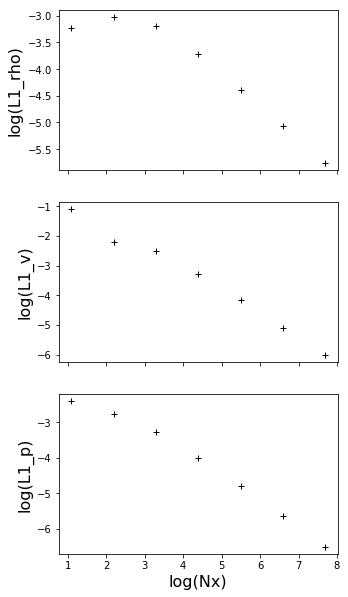

-0.4180715138 -2.21915069727
-0.718254458485 -0.329271783164
-0.636269182022 -1.40161183343


In [104]:
#Plotting L1 convergence for Sod

Nx_arr = [3**i for i in range(1,8)]
L1_arr_rho = [L1(Nxi)[0] for Nxi in Nx_arr]
L1_arr_v = [L1(Nxi)[1] for Nxi in Nx_arr]
L1_arr_p = [L1(Nxi)[2] for Nxi in Nx_arr]
fig, ax = plt.subplots(3, sharex = True, figsize=(5,10))
ax[0].plot(np.log(Nx_arr), np.log(L1_arr_rho), 'k+')
ax[0].set_ylabel('log(L1_rho)', fontsize=16)
ax[1].plot(np.log(Nx_arr), np.log(L1_arr_v), 'k+')
ax[1].set_ylabel('log(L1_v)', fontsize=16)
ax[2].plot(np.log(Nx_arr), np.log(L1_arr_p), 'k+')
ax[2].set_ylabel('log(L1_p)', fontsize=16)
ax[2].set_xlabel('log(Nx)', fontsize=16)
plt.show()

m,b = np.polyfit(np.log(Nx_arr), np.log(L1_arr_rho), 1)
print(m,b)
m,b = np.polyfit(np.log(Nx_arr), np.log(L1_arr_v), 1)
print(m,b)
m,b = np.polyfit(np.log(Nx_arr), np.log(L1_arr_p), 1)
print(m,b)